In [628]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotnine as pn
import statsmodels.api as sm
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

# Previous version (only protein emb, DNA LM data and sequence features used)
- seq_feats
- lm_3utr_emb
- lm_5utr_emb
- prot_emb

In [629]:
# DNA LM embeddings
#dnalm_df = pd.read_parquet('/s/project/multispecies/fungi_code/motif_discovery_pipeline/data/embeddings_non_sac_upstream/Saccharomyces_cerevisiae_BY4741/sequence_features_and_embeddings_Saccharomyces_cerevisiae_BY4741.parquet')
dnalm_df = pd.read_parquet('Data/dnalm_df.parquet')
dnalm_df.head()

,gene_id,embedding_upstream,embedding_downstream,five_prime_seq,cds,three_prime_seq,gc_5_prime,gc_3_prime,gc_cds,AAA,...,TCT,TGA,TGC,TGG,TGT,TTA,TTC,TTG,TTT,species
0,YAL002W,"[0.08123832, 0.030906273, 0.014586483, -0.0152...","[-0.02917197, 0.078893326, -0.05454025, 0.1706...",TTCCAAGGCCGATGAATTCGACTCTTTCCCAGCTGCCTCTGCTGCC...,ATGGAGCAAAATGGCCTTGACCACGACAGCAGATCTAGCATCGATA...,TAACATTTCTAAATATTTAATACAACTTTGGTTACATAAAAGTAAA...,0.365902,0.310000,0.372057,0.043956,...,0.031397,0.0,0.010989,0.010989,0.009419,0.031397,0.013344,0.032967,0.032967,Saccharomyces_cerevisiae_BY4741
1,YAL003W,"[0.032580532, 0.025513712, -0.031748626, -0.04...","[-0.030835396, -0.072578646, -0.05808209, 0.14...",CTTCATGTCAGCCTGCACTTCTGGGTCGTTGAAGTTTCTACCGATC...,ATGGCATCCACCGATTTCTCCAAGATTGAAACTTTGAAACAATTAA...,TAAAAGGCTTTTTTATAAACTTTTTATAATTAACATTAAAGCAAAA...,0.372881,0.253333,0.448220,0.009709,...,0.029126,0.0,0.000000,0.014563,0.004854,0.014563,0.043689,0.038835,0.004854,Saccharomyces_cerevisiae_BY4741
2,YAL004W,"[0.07244772, -0.004530292, 0.08222245, -0.0672...","[-0.032747507, -0.1945743, -0.083140165, 0.042...",CCAATTTGTCACCAGCTTCAGAAATGGTGTTCTTCAAAGAGTAAGC...,ATGGGTGTCACCAGCGGTGGCCTTAACTTCAAAGATACCGTCTTCA...,TAAATCAATACCGACAGCTTTTGACATATTATCTGTTATTTACTTG...,0.417747,0.346667,0.451163,0.023256,...,0.018605,0.0,0.000000,0.023256,0.009302,0.000000,0.055814,0.032558,0.000000,Saccharomyces_cerevisiae_BY4741
3,YAL008W,"[0.018979808, 0.34264776, -0.0416448, 0.006748...","[0.0005224135, -0.061880764, -0.061566852, 0.1...",GTGTCCGGGCCTCGCAGGCGTTCTACTAGCAAGACATCCAGTGCGA...,ATGACTTTGGCTTTTAATATGCAACGGTTGGTGTTTCGTAATTTGA...,TGAGCAAGACAAATGACCAGATATAAACGAGGGTTATATTCTTTCG...,0.381854,0.296667,0.388889,0.045455,...,0.020202,0.0,0.000000,0.015152,0.005051,0.055556,0.025253,0.065657,0.040404,Saccharomyces_cerevisiae_BY4741
4,YAL009W,"[-0.009528967, 0.003373141, 0.000113023896, -0...","[-0.01995761, -0.24868764, -0.054501917, 0.086...",CAAGATAATGTCAAAGTTAGTGGTCGTCCTGTGTTTGTAGAATGTG...,ATGGAGCCAGAGAGCATAGGCGATGTGGGGAACCATGCCCAGGATG...,TGAAAGAGTTGGAGGGCTTCTTCCTTCGAATAAGAGGTCATATTTA...,0.368893,0.323333,0.414414,0.042471,...,0.023166,0.0,0.000000,0.023166,0.007722,0.011583,0.027027,0.019305,0.038610,Saccharomyces_cerevisiae_BY4741


In [630]:
# Sequence features
seq_feats = dnalm_df[['gene_id'] + list(dnalm_df.iloc[:, 6:-1].columns)].dropna()
seq_feats.head()

,gene_id,gc_5_prime,gc_3_prime,gc_cds,AAA,AAC,AAG,AAT,ACA,ACC,...,TCG,TCT,TGA,TGC,TGG,TGT,TTA,TTC,TTG,TTT
0,YAL002W,0.365902,0.310000,0.372057,0.043956,0.019623,0.018053,0.039246,0.013344,0.007849,...,0.006279,0.031397,0.0,0.010989,0.010989,0.009419,0.031397,0.013344,0.032967,0.032967
1,YAL003W,0.372881,0.253333,0.448220,0.009709,0.024272,0.077670,0.004854,0.000000,0.019417,...,0.000000,0.029126,0.0,0.000000,0.014563,0.004854,0.014563,0.043689,0.038835,0.004854
2,YAL004W,0.417747,0.346667,0.451163,0.023256,0.023256,0.000000,0.046512,0.004651,0.074419,...,0.000000,0.018605,0.0,0.000000,0.023256,0.009302,0.000000,0.055814,0.032558,0.000000
3,YAL008W,0.381854,0.296667,0.388889,0.045455,0.020202,0.040404,0.050505,0.015152,0.005051,...,0.000000,0.020202,0.0,0.000000,0.015152,0.005051,0.055556,0.025253,0.065657,0.040404
4,YAL009W,0.368893,0.323333,0.414414,0.042471,0.011583,0.023166,0.027027,0.011583,0.007722,...,0.003861,0.023166,0.0,0.000000,0.023166,0.007722,0.011583,0.027027,0.019305,0.038610


In [631]:
# Upstream sequence embedding
lm_5utr_emb = pd.DataFrame(np.stack(dnalm_df.dropna().embedding_upstream.values), index=dnalm_df.dropna().gene_id)
lm_5utr_emb.head()

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
gene_id,,,,,,,,,,,,,,,,,,,,,
YAL002W,0.081238,0.030906,0.014586,-0.015279,0.028113,0.121253,0.068083,0.171768,-0.014086,0.544913,...,-0.030622,-0.045234,-0.263034,0.105608,0.000841,-0.068895,0.092609,0.012248,0.040396,-0.008431
YAL003W,0.032581,0.025514,-0.031749,-0.042321,-0.052058,0.100852,-0.040193,0.227620,-0.041441,0.127843,...,-0.004374,-0.035856,-0.159351,0.127666,0.066430,-0.019931,0.045678,0.022475,-0.025326,-0.090283
YAL004W,0.072448,-0.004530,0.082222,-0.067203,-0.010486,-0.015001,0.229780,0.198991,-0.101902,0.422294,...,-0.029051,-0.134829,-0.129500,0.040292,0.037237,0.001085,0.122111,0.084727,0.389339,0.085969
YAL008W,0.018980,0.342648,-0.041645,0.006749,-0.031477,0.081134,0.195077,0.200070,-0.049627,0.392190,...,0.044176,-0.022111,-0.216389,0.075199,0.044513,-0.020134,0.051188,0.055149,-0.255109,-0.061252
YAL009W,-0.009529,0.003373,0.000113,-0.007516,-0.010976,0.063841,0.181502,0.260650,-0.035609,0.194044,...,-0.007081,0.005693,-0.196746,0.071950,0.073255,0.002211,0.107910,-0.004822,-0.406600,-0.065601


In [632]:
# Downstream sequence embedding
lm_3utr_emb = pd.DataFrame(np.stack(dnalm_df.dropna().embedding_downstream.values), index=dnalm_df.dropna().gene_id)
lm_3utr_emb.head()

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
gene_id,,,,,,,,,,,,,,,,,,,,,
YAL002W,-0.029172,0.078893,-0.054540,0.170680,-0.107067,-0.092142,0.094663,-0.073110,0.010419,0.073653,...,0.078681,0.033648,0.014682,-0.074566,0.052284,0.034215,0.132639,0.110446,-0.013290,0.052378
YAL003W,-0.030835,-0.072579,-0.058082,0.145516,0.149264,-0.134691,0.159887,-0.117146,0.021611,0.060180,...,0.033926,0.019848,-0.004159,-0.071930,0.093962,-0.118783,0.159958,0.053212,-0.016180,-0.016293
YAL004W,-0.032748,-0.194574,-0.083140,0.042409,-0.167408,-0.126880,0.001361,-0.057888,0.031826,0.058797,...,0.064126,0.029112,-0.026013,-0.039213,0.102791,-0.111031,0.153221,0.017565,0.043769,0.003665
YAL008W,0.000522,-0.061881,-0.061567,0.106177,0.190146,-0.093892,0.050411,-0.155466,-0.009316,-0.006226,...,0.088757,0.043351,-0.037464,-0.073037,0.038244,-0.024653,-0.003237,0.044000,0.024346,0.006319
YAL009W,-0.019958,-0.248688,-0.054502,0.086972,0.208853,0.028963,-0.019007,-0.138868,-0.011246,0.009775,...,0.073859,0.001456,-0.025106,-0.022704,0.054237,-0.049160,-0.003523,0.056109,-0.006815,0.032631


In [633]:
# Protein embeddings from ESM2
#dataset = pd.read_pickle("/s/project/semi_supervised_multispecies/Downstream/Sequences/Annotation/Sequences/saccharomyces_cerevisiae/all_w_protein_seqs_embs.pickle")
#prot_emb = pd.DataFrame(np.stack(dataset.protein_emb.dropna().values), index=dataset.gene_id)
prot_emb = pd.read_parquet('Data/protein_emb.parquet')
prot_emb.head()

,0,1,2,3,4,5,6,7,8,9,...,1270,1271,1272,1273,1274,1275,1276,1277,1278,1279
gene_id,,,,,,,,,,,,,,,,,,,,,
YAL037W,0.077271,-0.057495,0.052307,0.074829,0.021423,-0.085205,0.071228,0.095398,0.028702,0.050751,...,0.134277,0.072266,-0.021713,0.066406,0.005680,0.021194,0.082520,-0.128540,-0.082214,-0.041718
YAL016W,0.064758,0.026871,-0.037994,0.045532,-0.023880,-0.051514,0.044617,-0.152832,0.023239,0.023300,...,0.158203,0.056488,-0.054749,0.015411,-0.078064,0.029373,0.055328,-0.112305,-0.038544,0.107849
YAL003W,0.074219,-0.017822,-0.073120,0.050598,0.026871,0.065979,0.068481,-0.242920,0.031342,0.042450,...,0.030151,-0.015701,-0.027069,0.044128,-0.043304,-0.096680,-0.028107,-0.229614,-0.015327,0.076904
YAL053W,-0.002195,-0.014854,-0.033875,0.077026,-0.005131,-0.097351,0.085815,-0.107666,-0.033203,0.048950,...,0.139893,0.009560,-0.075989,0.025589,-0.024933,-0.044464,0.020859,-0.033234,-0.054749,0.038361
YAL031W-A,0.049866,0.035248,0.141846,0.016281,-0.022156,-0.022507,-0.046112,0.180176,0.170898,0.080444,...,0.090759,0.108032,-0.091125,0.139648,-0.069824,0.188232,0.010498,0.062744,-0.078430,0.033264


In [634]:
def zscore_matrix(mat):
    m = np.mean(np.array(mat, dtype=np.float32).flatten())
    sd = np.std(np.array(mat, dtype=np.float32).flatten())

    mat_z = (mat - m)/sd
    return mat_z

In [635]:
%%time

seq_feats = seq_feats.set_index('gene_id')
# seq_feats_z = zscore_matrix(seq_feats)
# seq_feats_z = seq_feats_z.reset_index()

prot_emb_z = zscore_matrix(prot_emb)
prot_emb_z.columns = prot_emb_z.columns.astype(str)
prot_emb_z.columns = 'ESM2_' + prot_emb_z.columns
prot_emb_z = prot_emb_z.reset_index()

lm_3utr_emb_z = zscore_matrix(lm_3utr_emb)
lm_3utr_emb_z.columns = lm_3utr_emb_z.columns.astype(str)
lm_3utr_emb_z.columns = 'LM_3UTR_' + lm_3utr_emb_z.columns
lm_3utr_emb_z = lm_3utr_emb_z.reset_index()

lm_5utr_emb_z = zscore_matrix(lm_5utr_emb)
lm_5utr_emb_z.columns = lm_5utr_emb_z.columns.astype(str)
lm_5utr_emb_z.columns = 'LM_5UTR_' + lm_5utr_emb_z.columns
lm_5utr_emb_z = lm_5utr_emb_z.reset_index()

# Merge all the embeddings to get a per gene S.cerevisiae embedding
yeast_emb_full = seq_feats.merge(prot_emb_z, on='gene_id').merge(lm_3utr_emb_z, on='gene_id').merge(lm_5utr_emb_z, on='gene_id')
yeast_emb_full

CPU times: user 146 ms, sys: 39.1 ms, total: 185 ms
Wall time: 192 ms


,gene_id,gc_5_prime,gc_3_prime,gc_cds,AAA,AAC,AAG,AAT,ACA,ACC,...,LM_5UTR_758,LM_5UTR_759,LM_5UTR_760,LM_5UTR_761,LM_5UTR_762,LM_5UTR_763,LM_5UTR_764,LM_5UTR_765,LM_5UTR_766,LM_5UTR_767
0,YAL002W,0.365902,0.310000,0.372057,0.043956,0.019623,0.018053,0.039246,0.013344,0.007849,...,-0.078495,-0.101951,-0.451596,0.140201,-0.027987,-0.139936,0.119334,-0.009675,0.035513,-0.042870
1,YAL003W,0.372881,0.253333,0.448220,0.009709,0.024272,0.077670,0.004854,0.000000,0.019417,...,-0.036358,-0.086898,-0.285149,0.175611,0.077306,-0.061331,0.043992,0.006744,-0.069993,-0.174272
2,YAL004W,0.417747,0.346667,0.451163,0.023256,0.023256,0.000000,0.046512,0.004651,0.074419,...,-0.075972,-0.245783,-0.237227,0.035347,0.030442,-0.027595,0.166694,0.106680,0.595686,0.108673
3,YAL008W,0.381854,0.296667,0.388889,0.045455,0.020202,0.040404,0.050505,0.015152,0.005051,...,0.041582,-0.064832,-0.376715,0.091384,0.042122,-0.061658,0.052838,0.059197,-0.438873,-0.127666
4,YAL009W,0.368893,0.323333,0.414414,0.042471,0.011583,0.023166,0.027027,0.011583,0.007722,...,-0.040703,-0.020197,-0.345180,0.086169,0.088264,-0.025787,0.143896,-0.037077,-0.682068,-0.134648
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6574,YPR195C,0.334995,0.393333,0.467890,0.027523,0.000000,0.000000,0.027523,0.045872,0.009174,...,-0.069516,-0.091421,-0.402476,0.095457,0.023955,-0.072979,-0.082304,0.072628,-0.665834,0.037950
6575,YPR197C,0.376869,0.276667,0.374332,0.058824,0.021390,0.021390,0.016043,0.042781,0.005348,...,-0.014195,-0.102008,-0.424302,0.133435,0.087042,-0.024667,0.205772,0.009731,-0.687237,0.048592
6576,YPR199C,0.329013,0.283333,0.391156,0.030612,0.020408,0.047619,0.047619,0.027211,0.003401,...,0.052901,-0.037409,-0.385326,0.083647,0.060815,-0.034371,0.054171,0.069161,-0.484573,-0.094109
6577,YPR200C,0.366899,0.313333,0.376923,0.038462,0.015385,0.038462,0.023077,0.030769,0.015385,...,0.087128,-0.082817,-0.418286,0.099563,0.080339,-0.000032,0.105696,0.047736,-0.490977,0.055293


In [636]:
# Yeast Net data
YeastNetdata = pd.read_csv('data/YeastNet.csv', sep = ',', index_col = 0)

In [637]:
YeastNetdata


,gene1,gene2,edge_value
0,YBL039C,YGR103W,3.713364
1,YDL060W,YDR101C,3.701611
2,YDL060W,YNL248C,3.693862
3,YDR101C,YOR004W,3.665467
4,YDL148C,YNL062C,3.660805
...,...,...,...
242499,YDL037C,YJL079C,0.811086
242500,YCL044C,YDL211C,0.811083
242501,YGR078C,YJR097W,0.811081
242502,YBR052C,YOR227W,0.811079


In [638]:
YeastNetdata.to_csv("data/YeastNet.edg", sep="\t", columns=["gene1", "gene2", "edge_value"], header=False, index=False)


In [639]:
!pecanpy --input "data/YeastNet.edg" --output "data/YeastNetEmbeddings.npz" --mode SparseOTF --weighted


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pecanpy/cli.py:302: UserWarning: When p = 1 and q = 1, it is highly recommended to use PreCompFirstOrder over SparseOTF (current selection). The runtime could be improved greatly with low memory usage.
  check_mode(g, args)
Took 00:00:00.34 to load Graph
Took 00:00:00.00 to pre-compute transition probabilities
Took 00:00:03.45 to generate walks
Took 00:00:04.29 to train embeddings


In [640]:
yeastnet_embeddings_npz = np.load("data/YeastNetEmbeddings.npz")
yeastnet_embeddings = pd.DataFrame(np.stack(yeastnet_embeddings_npz["data"]), index=yeastnet_embeddings_npz["IDs"]).add_prefix("yeastnet_")
yeastnet_embeddings

yeastnet_emb_z = zscore_matrix(yeastnet_embeddings)
yeastnet_emb_z.columns = yeastnet_emb_z.columns.astype(str)
yeastnet_emb_z = yeastnet_emb_z.reset_index()
yeastnet_emb_z.rename(columns={'index':'gene_id'}, inplace=True)

# m = np.mean(np.array(yeastnet_emb_z.iloc[:,1:], dtype=np.float32).flatten())
# sd = np.std(np.array(yeastnet_emb_z.iloc[:,1:], dtype=np.float32).flatten())
# print(m, sd)

yeastnet_emb_z

,gene_id,yeastnet_0,yeastnet_1,yeastnet_2,yeastnet_3,yeastnet_4,yeastnet_5,yeastnet_6,yeastnet_7,yeastnet_8,...,yeastnet_118,yeastnet_119,yeastnet_120,yeastnet_121,yeastnet_122,yeastnet_123,yeastnet_124,yeastnet_125,yeastnet_126,yeastnet_127
0,YBR247C,0.862545,1.787457,0.478768,1.242958,-1.145739,-1.995192,-2.438822,-0.112374,0.876396,...,1.181709,0.476386,1.608626,2.146405,-1.842731,-2.139195,-1.172446,0.601851,0.569501,0.024797
1,YBR142W,0.215896,1.389278,1.735440,2.060464,-1.593058,-2.342977,-1.881868,-0.890851,1.138842,...,1.820383,-0.109526,1.106090,0.654434,-1.512608,-1.500555,-0.079463,0.255262,0.907318,0.342049
2,YDL060W,0.136202,1.650746,0.259597,1.922614,-1.410351,-1.805220,-2.163422,-1.213424,1.312042,...,1.489068,0.615426,0.786098,1.712473,-1.796996,-2.085330,-0.297562,0.006435,0.747070,0.921885
3,YBL039C,1.496436,1.758737,0.640876,1.220598,-0.935134,-1.877591,-2.003955,-0.462133,1.287197,...,1.362604,1.333746,0.395414,1.469699,-1.290446,-1.663609,-0.551579,0.427150,0.822049,0.461080
4,YAL059W,0.543401,1.626237,0.965303,1.511806,-1.738749,-2.032647,-2.106317,-0.051257,0.737260,...,1.624722,-0.747304,0.971680,1.650852,-0.757032,-2.758241,0.241948,-0.418355,0.574010,0.846151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5725,YGR035W-A,0.091682,1.568634,-0.865762,0.966340,-0.503474,-0.929361,-0.667670,-0.433037,0.727018,...,0.501145,0.975427,-1.012233,0.634759,0.042800,-0.522082,0.035560,0.985917,0.689534,0.594116
5726,YBR296C-A,0.370831,1.263987,0.218285,0.596372,-0.664988,-1.047256,-0.983056,-0.565679,0.614832,...,0.862784,0.237155,-0.146248,0.871165,-0.495645,-0.905884,-0.138436,0.212351,0.714116,0.140711
5727,YOR316C-A,0.180412,1.323962,-0.174854,0.472138,-0.535242,-0.764736,-0.395249,-0.356489,0.805924,...,0.628009,0.432557,-0.450690,0.591750,-0.443015,-0.595573,-0.131251,0.661514,0.493066,0.229812
5728,YPL165C,0.321460,0.977202,-0.242980,0.334430,-0.501438,-0.653523,-0.552838,-0.544508,0.750671,...,0.392201,0.402422,-0.733176,0.548539,-0.320428,-0.443147,-0.000005,0.666483,0.470499,-0.211327


In [641]:
# Gene expression and fitness data
data_experiment_decriptions= pd.read_csv('Data/yp_screens_haphom_20221025.txt', sep = '\t', index_col = 0)
data_Turco = pd.read_csv('Data/yp_matrix_z_haphom_20221025.txt', sep = '\t', index_col = 0)
data_Turco.index.name = "gene_id"  

In [642]:
data_experiment_decriptions

,name,collection,phenotype,conditionset,medium,paper,pmid,latest_tested_status,num_tested
id,,,,,,,,,
1,hap a | growth (streaks on agar) | rapamycin [...,hap a,growth (streaks on agar),rapamycin [25 nM],YPD,"Chan TF~Zheng XF, 2000 - 11078525",11078525,request abandoned,2216
2,hap a | NHEJ | standard | SC - Ura | Ooi SL~Bo...,hap a,NHEJ,standard,SC - Ura,"Ooi SL~Boeke JD, 2001 - 11701889",11701889,request abandoned,4647
4,hap alpha | growth (exponential growth rate) |...,hap alpha,growth (exponential growth rate),ethanol [8%],YPD,"Yoshikawa K~Shimizu H, 2009 - 19054128",19054128,loaded,4729
5,hap alpha | growth (exponential growth rate) |...,hap alpha,growth (exponential growth rate),sodium chloride [1 M],YPD,"Yoshikawa K~Shimizu H, 2009 - 19054128",19054128,loaded,4729
7,hap a | growth (colony size) | streptomycin [4...,hap a,growth (colony size),streptomycin [40 mg/ml],SC,"Alamgir M~Golshani A, 2010 - 20691087",20691087,loaded,4669
...,...,...,...,...,...,...,...,...,...
22217,"hom | growth (pooled culture, barseq) | gadoli...",hom,"growth (pooled culture, barseq)","gadolinium [IC20], time [15 gen]",YPD,"Pallares RM~Abergel RJ, 2022 - 35040455",35040455,loaded,4291
22218,hap a | protein transport to the vacuole (Sec6...,hap a,protein transport to the vacuole (Sec61-mCherr...,rapamycin [200 ug/L],SC - Leu,"Chen S~Ferro-Novick S, 2020 - 32690699",32690699,request abandoned,0
22219,hap a | mating creep | opposite mating type st...,hap a,mating creep,opposite mating type strain [MAT alpha (BY4742)],YPD,"Arras SDM~Ganley ARD, 2022 - 35298616",35298616,loaded,4929


In [643]:
data_Turco


,1,2,4,5,7,8,9,10,11,14,...,22212,22213,22214,22215,22216,22217,22218,22219,22220,22228
gene_id,,,,,,,,,,,,,,,,,,,,,
YAL002W,-0.071896,0.0,-0.351851,-0.272362,0.021981,-0.672391,-0.243525,-0.291566,-2.623798,1.015551,...,0.013849,-0.089649,-0.030395,-0.059043,-0.006962,-0.078004,-8.335666,0.0,NaN,-1.692692
YAL005C,-0.071896,0.0,-0.539305,-0.282393,-0.237616,-0.290585,-0.134638,0.249022,NaN,-0.984568,...,0.013849,-0.089649,-0.030395,-0.059043,-0.006962,-0.078004,0.000000,0.0,NaN,-2.003358
YAL007C,-0.071896,0.0,-0.316477,-1.716964,0.669387,0.352375,0.557858,0.136025,1.104770,-0.291439,...,0.013849,-0.089649,-0.030395,-0.059043,-0.006962,-0.078004,0.000000,0.0,NaN,-1.374965
YAL008W,-0.071896,0.0,-0.247000,-0.095510,1.414719,0.122065,-0.573721,-1.002780,0.211580,0.262476,...,0.013849,-0.089649,-0.030395,-0.059043,-0.006962,-8.079187,0.000000,0.0,NaN,0.640416
YAL009W,-4.817055,0.0,-2.212226,-1.010491,-0.250085,-0.016314,-0.030528,-0.013983,0.233321,NaN,...,0.013849,-0.089649,-0.030395,-0.059043,-0.006962,-0.078004,0.000000,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YPR196W,-0.071896,0.0,-0.320923,-0.872477,1.552995,-0.010449,-0.140292,-1.044475,-0.102829,-0.233030,...,0.013849,-0.089649,-0.030395,-0.059043,-0.006962,-0.078004,0.000000,0.0,-1.337041,-0.130582
YPR198W,-0.071896,0.0,-0.705077,-0.958221,0.799231,0.193457,0.143067,1.181440,0.186180,-0.443869,...,0.013849,-0.089649,-0.030395,-0.059043,-0.006962,-0.078004,0.000000,0.0,-0.492903,-1.622164
YPR199C,-0.071896,0.0,-0.228440,-0.432992,0.423262,-0.940111,3.520616,0.321456,-0.192618,-0.308187,...,0.013849,-0.089649,-0.030395,-0.059043,-0.006962,-0.078004,0.000000,0.0,-0.047430,1.573639


In [644]:
# filter for gene expression data from experiment_descriptions
gene_expressions = data_experiment_decriptions[data_experiment_decriptions["phenotype"].str.contains("expression of", na=False)]
expression_ids = gene_expressions.index.astype(str)
expression_ids

# access the gene expression columns in data_Turco
data_Turco_gene_expressions = data_Turco[expression_ids]
data_Turco_gene_expressions

,14,575,576,5658,5659,5660,5661,5662,5663,5664,...,16249,16250,16445,16683,16684,16685,16692,21877,21888,21932
gene_id,,,,,,,,,,,,,,,,,,,,,
YAL002W,1.015551,0.0,0.0,0.166776,0.593701,0.881766,-1.825381,-4.183916,-2.297258,3.148642,...,0.039332,0.039744,-2.121822,-1.766094,-1.222334,-0.899787,0.0,0.0,0.718919,1.315787
YAL005C,-0.984568,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.039332,0.039744,NaN,0.198761,-0.359510,-0.518293,0.0,0.0,-1.741585,0.268343
YAL007C,-0.291439,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.039332,0.039744,-2.363746,0.711531,0.071902,0.244696,0.0,0.0,NaN,NaN
YAL008W,0.262476,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.039332,0.039744,-2.827468,0.936046,0.934726,1.961420,0.0,0.0,0.495987,0.889903
YAL009W,NaN,0.0,0.0,0.222402,0.813596,0.150954,-0.021129,-1.063710,-0.019370,-0.502173,...,-3.854544,0.039744,1.223983,NaN,NaN,NaN,0.0,0.0,0.198745,-0.307176
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YPR196W,-0.233030,0.0,0.0,-0.054603,-0.431040,-0.604339,-0.752402,-0.100895,0.211024,0.431753,...,0.039332,0.039744,0.310691,0.447998,0.287608,1.007684,0.0,0.0,-0.858116,-0.560404
YPR198W,-0.443869,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.039332,0.039744,NaN,-0.339980,0.503314,0.053949,0.0,0.0,-1.254438,-0.146031
YPR199C,-0.308187,0.0,0.0,0.331140,0.284583,0.038758,-0.752012,-0.173785,0.372366,0.625433,...,0.039332,0.039744,-0.932724,1.014407,0.503314,0.435443,0.0,0.0,-0.734265,-0.445300


In [645]:
# Fixing data_Turco_gene expressions
# Still open to modification 

# removes columns with around over > 45% NaN values
data_Turco_gene_expressions = data_Turco_gene_expressions.loc[:, data_Turco_gene_expressions.isna().sum() <= 2000]

# Fill remaining NaN values with the mean of the column
data_Turco_gene_expressions = data_Turco_gene_expressions.fillna(data_Turco_gene_expressions.mean())

# remove the columns that are filled with > 45% zeros
data_Turco_gene_expressions = data_Turco_gene_expressions.loc[:, (data_Turco_gene_expressions == 0).sum() <= 2000]

# remove the columns that are filled with > 45% dummy values 
#dummy_counts = data_Turco_gene_expressions.apply(lambda col: col.value_counts().iloc[0])
#data_Turco_gene_expressions = data_Turco_gene_expressions.loc[:, dummy_counts <= 2000]

data_Turco_gene_expressions

,14,11807,11808,16247,16248,16249,16250,16445,16683,16684,16685,21888,21932
gene_id,,,,,,,,,,,,,
YAL002W,1.015551,1.972265,-1.441269,0.032064,0.032865,0.039332,0.039744,-2.121822,-1.766094,-1.222334,-0.899787,0.718919,1.315787
YAL005C,-0.984568,-0.612589,0.479318,0.032064,0.032865,0.039332,0.039744,-0.056227,0.198761,-0.359510,-0.518293,-1.741585,0.268343
YAL007C,-0.291439,1.655540,0.022315,0.032064,0.032865,0.039332,0.039744,-2.363746,0.711531,0.071902,0.244696,-0.342359,0.223590
YAL008W,0.262476,0.244914,0.107434,0.032064,0.032865,0.039332,0.039744,-2.827468,0.936046,0.934726,1.961420,0.495987,0.889903
YAL009W,-0.279760,0.274440,0.110464,0.032064,0.032865,-3.854544,0.039744,1.223983,-0.047052,-0.069950,-0.013320,0.198745,-0.307176
...,...,...,...,...,...,...,...,...,...,...,...,...,...
YPR196W,-0.233030,-1.095670,-0.241713,0.032064,0.032865,0.039332,0.039744,0.310691,0.447998,0.287608,1.007684,-0.858116,-0.560404
YPR198W,-0.443869,-0.959960,-0.095216,3.206382,0.032865,0.039332,0.039744,-0.056227,-0.339980,0.503314,0.053949,-1.254438,-0.146031
YPR199C,-0.308187,-0.116135,-0.086297,0.032064,0.032865,0.039332,0.039744,-0.932724,1.014407,0.503314,0.435443,-0.734265,-0.445300


In [646]:
# add data Turco gene expressions
data_Turco_gene_expressions_z = zscore_matrix(data_Turco_gene_expressions)
data_Turco_gene_expressions_z.columns = data_Turco_gene_expressions_z.columns.astype(str)
data_Turco_gene_expressions_z.columns = 'data_Turco_' + data_Turco_gene_expressions_z.columns
data_Turco_gene_expressions_z = data_Turco_gene_expressions_z.reset_index()

data_Turco_gene_expressions_z

,gene_id,data_Turco_14,data_Turco_11807,data_Turco_11808,data_Turco_16247,data_Turco_16248,data_Turco_16249,data_Turco_16250,data_Turco_16445,data_Turco_16683,data_Turco_16684,data_Turco_16685,data_Turco_21888,data_Turco_21932
0,YAL002W,1.185656,2.222560,-1.477089,0.119735,0.120603,0.127613,0.128059,-2.214685,-1.829140,-1.239804,-0.890221,0.864161,1.511058
1,YAL005C,-0.982109,-0.578951,0.604477,0.119735,0.120603,0.127613,0.128059,0.024044,0.300405,-0.304660,-0.476751,-1.802578,0.375819
2,YAL007C,-0.230883,1.879288,0.109169,0.119735,0.120603,0.127613,0.128059,-2.476886,0.856154,0.162912,0.350190,-0.286071,0.327314
3,YAL008W,0.369460,0.350426,0.201423,0.119735,0.120603,0.127613,0.128059,-2.979477,1.099488,1.098057,2.210806,0.622544,1.049477
4,YAL009W,-0.218225,0.382427,0.204706,0.119735,0.120603,-4.092641,0.128059,1.411559,0.033988,0.009170,0.070547,0.300387,-0.247939
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4549,YPR196W,-0.167578,-1.102523,-0.176989,0.119735,0.120603,0.127613,0.128059,0.421716,0.570532,0.396699,1.177130,-0.845057,-0.522392
4550,YPR198W,-0.396090,-0.955439,-0.018213,3.560119,0.120603,0.127613,0.128059,0.024044,-0.283493,0.630485,0.143454,-1.274599,-0.073287
4551,YPR199C,-0.249035,-0.040886,-0.008547,0.119735,0.120603,0.127613,0.128059,-0.925920,1.184416,0.630485,0.556925,-0.710826,-0.397641
4552,YPR200C,-0.427806,0.079937,0.293871,0.119735,0.120603,0.127613,0.128059,-0.813766,0.632139,0.162912,0.763660,-1.131419,-0.746945


In [647]:
# Add yeast yeastnet data to the model
yeast_emb_full = yeast_emb_full.merge(yeastnet_emb_z, on="gene_id")

# Add data Turco gene expressions to the predictive model
yeast_emb_full = yeast_emb_full.merge(data_Turco_gene_expressions_z, on="gene_id")


0.8090417855051373


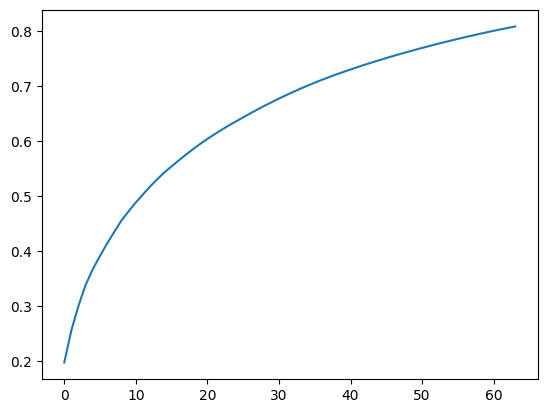

In [648]:
# Check what is the percentage of the variance explained by compressed data compared to the full data
N=64
pca = PCA(n_components=N)
pca.fit_transform(yeast_emb_full.iloc[:,1:])
ev = pca.explained_variance_ratio_.cumsum()
print(ev[-1])
plt.plot(range(0, N), ev)

In [649]:
dims = 64
emb_full_pca = pd.DataFrame(PCA(n_components=dims).fit_transform(yeast_emb_full.iloc[:,1:]), index=yeast_emb_full.gene_id).reset_index()
emb_full_pca

,gene_id,0,1,2,3,4,5,6,7,8,...,54,55,56,57,58,59,60,61,62,63
0,YAL002W,-1.263258,-3.647451,1.050551,-1.093734,-0.782772,-0.463617,-2.532639,0.671842,0.159861,...,-1.371816,-1.788531,-2.754826,-0.425975,0.835279,-0.091717,-0.779996,0.826347,-0.775659,-0.853042
1,YAL008W,-1.250918,-4.460056,-1.981418,-6.096442,0.916496,-0.480525,-2.615129,-0.869759,-0.094621,...,-1.881384,0.078633,-1.683407,0.144232,-2.098581,0.163572,-1.455066,-0.293860,-1.353964,-0.684361
2,YAL009W,-1.661507,1.214589,2.460142,-3.341978,2.195418,1.766752,0.634267,1.740830,3.153985,...,1.980746,-0.799315,0.300566,-1.386129,-0.884778,0.669428,0.756028,0.057925,0.176089,0.778366
3,YAL011W,-8.363179,2.181784,2.309707,-3.336420,-2.635638,0.026201,0.430981,2.313139,0.243511,...,-0.748437,-0.128435,-1.332218,0.295573,-1.196190,1.144653,-0.244914,1.162859,-0.528696,0.249139
4,YAL012W,15.494935,2.006264,-3.064869,2.711543,-0.242959,-0.296948,1.760234,3.618405,-0.257330,...,0.059738,-0.775315,-2.362164,1.867047,0.419476,0.783052,0.507023,-2.064694,0.480806,-2.099089
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4432,YPR188C,0.073753,0.208295,3.144515,-3.192100,3.036700,3.094751,-1.048266,0.801089,2.234300,...,0.575105,-0.094763,-0.304540,0.410392,0.179448,-1.490259,-0.332072,0.662644,0.459366,0.167541
4433,YPR193C,8.080034,-4.899810,-0.413120,-0.355696,1.348377,-0.110397,0.505540,0.870558,-1.206533,...,1.042420,1.606326,1.112022,-0.668995,1.460414,0.083934,0.942487,0.014942,-0.924739,-1.001253
4434,YPR194C,6.304869,-0.918830,0.484552,4.988493,-1.755308,0.187324,-2.430379,-2.759741,3.817081,...,-0.378909,0.430865,0.587509,0.055583,0.175135,-1.662492,0.355621,0.901282,-0.977249,0.732937
4435,YPR199C,-6.797490,-1.525518,0.258213,1.424947,-0.551695,0.450977,-1.589229,-1.698220,-0.435710,...,-1.291345,-0.733301,-0.741081,-0.763816,-0.307072,-1.007676,1.787430,0.873518,0.617469,0.898046


# Load the data, that is needed to be incorporated as well
- experimental gene-gene interaction by Costazo et al 2016 
- gene expression and fitness data
- Yeast Net

In [650]:
# Gene-gene interactions, they need to be combined, cause separatedly for essential and non-essential genes
GxG_data_Costanzo_ExE = pd.read_csv('Data/SGA_ExE_clustered.cdt', sep = '\t', dtype = 'str')
GxG_data_Costanzo_ExN = pd.read_csv('Data/SGA_ExN_clustered.cdt', sep = '\t', dtype = 'str')
GxG_data_Costanzo_NxN = pd.read_csv('Data/SGA_NxN_clustered.cdt', sep = '\t', dtype = 'str')

In [651]:
GxG_data_Costanzo_ExE 

,GID,Strain,ORF,Name,Label,GWEIGHT,tsa1184,tsa1067,tsa1100,tsa1111,...,tsa950,tsa367,tsa676,tsa859,tsa860,tsa989,tsa1034,tsa927,tsa1239,tsa932
0,AID,NaN,NaN,NaN,NaN,NaN,ARRY154X,ARRY47X,ARRY76X,ARRY87X,...,ARRY759X,ARRY405X,ARRY594X,ARRY697X,ARRY699X,ARRY777X,ARRY20X,ARRY742X,ARRY202X,ARRY745X
1,ORF,NaN,NaN,NaN,NaN,NaN,YDR478W,YHR040W,YIL104C,YDR064W,...,YBL034C,YBR055C,YLR105C,YDL103C,YDL103C,YKL104C,YKL024C,YOR074C,YDR081C,YOR204W
2,Name,NaN,NaN,NaN,NaN,NaN,SNM1,BCD1,SHQ1,RPS13,...,STU1,PRP6,SEN2,QRI1,QRI1,GFA1,URA6,CDC21,PDC2,DED1
3,Label,NaN,NaN,NaN,NaN,NaN,snm1-5001,bcd1-5001,shq1-5001,rps13-5001,...,stu1-7,prp6-ts,sen2-1,qri1-ts1,qri1-ts6,gfa1-97,ura6-6,cdc21-1,pdc2-5001,ded1-f144c
4,EWEIGHT,NaN,NaN,NaN,NaN,NaN,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
824,GENE519X,tsq26,YAL038W,CDC19,cdc19-1,1,0.041,0.028,0.042,0.006,...,-0.022,-0.005,-0.021,0.022,-0.004,0.017,0.027,-0.161,0.063,-0.028
825,GENE604X,tsq455,YBR055C,PRP6,prp6-1,1,0.024,-0.046,0.049,0.006,...,NaN,NaN,-0.003,0.004,0.048,0.036,0.067,0.099,0.054,0.016
826,GENE614X,tsq472,YGR091W,PRP31,prp31-1,1,0.058,0.067,0.019,-0.007,...,-0.043,-0.011,0.022,0.014,0.020,0.023,0.060,0.055,0.113,0.043
827,GENE721X,tsq676,YLR105C,SEN2,sen2-1,1,0.018,0.020,0.031,0.004,...,-0.069,-0.007,NaN,0.039,0.004,0.037,0.012,0.093,0.123,0.043


In [652]:
GxG_data_Costanzo_ExN 

,GID,Strain,ORF,Name,Label,GWEIGHT,dma3509,dma3243,dma3812,dma3908,...,dma750,dma3957,dma2604,dma998,dma4951,dma826,dma4263,dma4575,dma5223,dma615
0,AID,NaN,NaN,NaN,NaN,NaN,ARRY2010X,ARRY1794X,ARRY2271X,ARRY2338X,...,ARRY3621X,ARRY2368X,ARRY1268X,ARRY3825X,ARRY3104X,ARRY3675X,ARRY2508X,ARRY2790X,ARRY3328X,ARRY3507X
1,ORF,NaN,NaN,NaN,NaN,NaN,YML003W,YLR182W,YMR215W,YMR305C,...,YDL180W,YNL027W,YJL204C,YDR251W,YPL220W,YDL234C,YNR062C,YOR182C,YDR036C,YDL018C
2,Name,NaN,NaN,NaN,NaN,NaN,NaN,SWI6,GAS3,SCW10,...,NaN,CRZ1,RCY1,PAM1,RPL1A,GYP7,NaN,RPS30B,EHD3,ERP3
3,Label,NaN,NaN,NaN,NaN,NaN,yml003w,swi6,gas3,scw10,...,ydl180w,crz1,rcy1,pam1,rpl1a,gyp7,ynr062c,rps30b,ehd3,erp3
4,EWEIGHT,NaN,NaN,NaN,NaN,NaN,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2063,GENE1056X,sn543,YKL176C,LST4,lst4,1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2064,GENE20X,sn1089,YGR163W,GTR2,gtr2,1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2065,GENE2043X,tsq955,YLR321C,SFH1,sfh1-1,1,0.001,NaN,-0.005,0.013,...,0.007,0.038,-0.019,0.028,-0.012,-0.025,0.012,0.189,-0.038,0.003
2066,GENE1057X,sn544,YGR057C,LST7,lst7,1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [653]:
GxG_data_Costanzo_NxN 

,GID,Strain,ORF,Name,Label,GWEIGHT,dma1902,dma1903,dma3438,dma366,...,dma4474,dma3868,dma3921,dma3907,dma3910,dma3911,dma3918,dma4686,dma4867,dma5251
0,AID,NaN,NaN,NaN,NaN,NaN,ARRY690X,ARRY691X,ARRY1965X,ARRY2138X,...,ARRY2701X,ARRY2300X,ARRY2348X,ARRY2337X,ARRY2340X,ARRY2341X,ARRY2345X,ARRY2876X,ARRY3038X,ARRY3347X
1,ORF,NaN,NaN,NaN,NaN,NaN,YGR152C,YGR151C,YLR408C,YBR219C,...,YOR042W,YMR265C,YMR316C-B,YMR306C-A,YMR304C-A,YMR303C,YMR318C,YOR296W,YPL133C,YCR107W
2,Name,NaN,NaN,NaN,NaN,NaN,RSR1,NaN,BLS1,NaN,...,CUE5,NaN,NaN,NaN,NaN,ADH2,ADH6,NaN,RDS2,AAD3
3,Label,NaN,NaN,NaN,NaN,NaN,rsr1,ygr151c,bls1,ybr219c,...,cue5,ymr265c,ymr316c-b,ymr306c-a,ymr304c-a,adh2,adh6,yor296w,rds2,aad3
4,EWEIGHT,NaN,NaN,NaN,NaN,NaN,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3283,GENE3020X,sn672,YGR041W,BUD9,bud9,1,NaN,NaN,0.059,0.043,...,-0.005,0.002,0.030,0.040,-0.021,-0.004,0.079,0.011,0.044,0.007
3284,GENE3044X,sn701,YLR020C,YEH2,yeh2,1,0.002,0.050,-0.005,-0.012,...,-0.004,0.036,-0.000,0.009,0.105,0.056,0.135,-0.001,0.052,0.005
3285,GENE3143X,sn825,YKR102W,FLO10,flo10,1,-0.022,-0.060,-0.011,-0.044,...,0.048,0.019,0.006,0.026,0.001,0.053,0.102,-0.081,0.018,-0.011
3286,GENE3052X,sn711,YBL043W,ECM13,ecm13,1,-0.059,0.006,-0.199,-0.035,...,0.001,0.029,-0.040,0.002,-0.004,-0.006,0.001,0.006,0.043,-0.019


# Simple evaluation on single mutant fitness data

In [654]:
# Read in single mutant fitness data from Constanzo et al. 2016
smf_filter = pd.read_csv('Data/smf.csv', index_col = 0)

<Axes: >

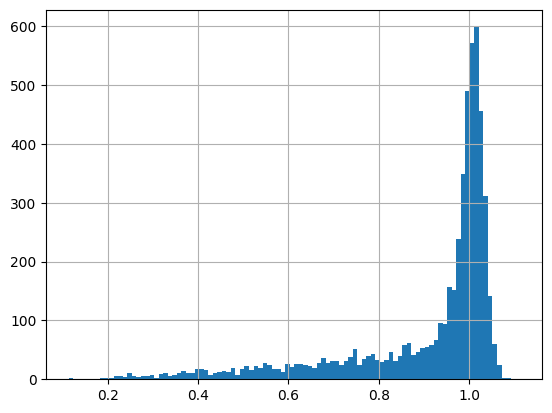

In [655]:
smf_filter.smf_30.hist(bins=100)

In [656]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

R2:  0.34370193361576773


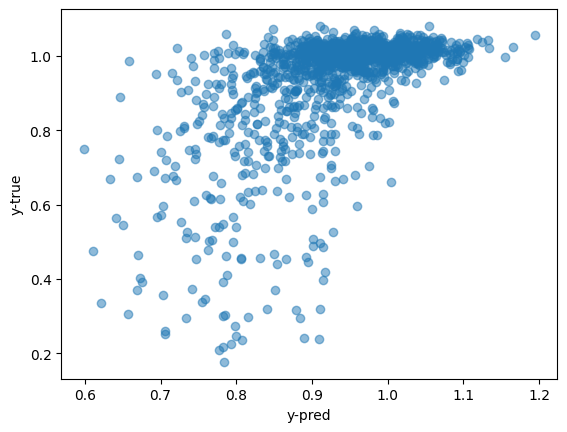

In [657]:
# How predictive are gene embeddings

A = smf_filter.merge(emb_full_pca, on='gene_id', how='inner').dropna()
X = A.iloc[:, 5:]
y = A['smf_30']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

lm = LinearRegression().fit(X_train, y_train)
print('R2: ', lm.score(X_test, y_test))

plt.scatter(lm.predict(X_test), y_test, alpha=0.5)
plt.xlabel("y-pred")
plt.ylabel("y-true")
plt.show()

R2:  0.34370193361576773


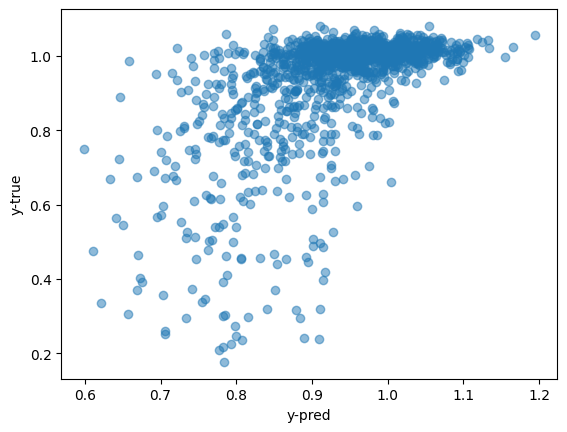

In [658]:
# Comparison to only sequence features

A = smf_filter.merge(seq_feats, on='gene_id', how='inner').dropna()
X = A.iloc[:, 5:]
y = A['smf_30']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

lm = LinearRegression().fit(X_train, y_train)
print('R2: ', lm.score(X_test, y_test))

plt.scatter(lm.predict(X_test), y_test, alpha=0.5)
plt.xlabel("y-pred")
plt.ylabel("y-true")
plt.show()

In [659]:
#genesTab = pd.read_csv("Data/odb10v1_genes.tab", sep='\t', low_memory=False)
#genesTab

In [660]:
#OG2genesTab = pd.read_csv("Data/odb10v1_OG2genes.tab", sep='\t', low_memory=False)
#OG2genesTab